In [1]:
import numpy as np
import cv2 as cv
import os

In [2]:
path = "images-photographes"

In [3]:
def load_dataset(dir_sc, images_per_class=None):
    inames = []
    ilabels = []
    cnames = sorted(os.listdir(dir_sc))
    for ilabel, cl in enumerate(cnames):
        dir_cl = os.path.join(dir_sc, cl)
        for iname in os.listdir(dir_cl)[:images_per_class]:
            inames.append(os.path.join(cl, iname))
            ilabels.append(ilabel)
    ilabels = np.array(ilabels)
    return inames, ilabels, cnames


### SIFT

In [9]:
def ComputeSift(I,p):
    gray= cv.cvtColor(I,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    img = cv.drawKeypoints(gray,kp,I,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.imwrite(os.path.join('Sifts',p), img)
    #print(os.path.join('Sifts',p))
    #cv.imshow('First Image',img)
    #cv.waitKey()
    #cv.destroyAllWindows()
    return kp, des

In [5]:
def ComputeSiftDataset(inames):
    keypoints = []
    descriptors = []
    for x in inames:
        p = os.path.join(path, x)
        #print(p)
        img = cv.imread(p)
        kp, des = ComputeSift(img, x)
        keypoints.append(kp)
        descriptors.append(des)
    
    return keypoints, descriptors
        
    

In [7]:
inames, ilabels, class_names = load_dataset(path)

In [8]:
class_names

['daido-moriyama',
 'dorothea-lange',
 'felix-nadar',
 'henri-cartier-bresson',
 'irving-penn',
 'malik-sidibe',
 'marc-riboud',
 'seidou-keita',
 'shomei-tomatsu',
 'walter-evans']

In [17]:
ilabels.shape

(280,)

In [10]:
keypoints, descriptors = ComputeSiftDataset(inames)

In [16]:
len(descriptors)

280

In [13]:
from sklearn.cluster import KMeans

In [21]:
def compute_split(length, seed=1337, pc=0.80):
    train_ids = np.random.RandomState(seed=seed).choice(
        length,
        size=int(length * pc),
        replace=False)
    test_ids = np.array(list(set(np.arange(length)) - set(train_ids)))
    return train_ids, test_ids

In [22]:
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    zeros_vect = np.zeros((128))
    kmeans = KMeans(n_clusters=n_clusters).fit(sift)
    centers = kmeans.cluster_centers_
    np.append(centers, zeros_vect)
    vdict = centers

    return vdict

In [23]:
vdict = compute_visual_dict(descriptors)
vdict

array([[20.353382 , 18.150375 , 16.458645 , ...,  8.706766 ,  6.5714273,
        17.834587 ],
       [29.868422 , 17.578945 ,  8.328947 , ...,  1.3026304,  2.8815794,
         4.3026314],
       [31.351353 , 16.36036  , 21.747747 , ..., 14.765766 , 21.711712 ,
        23.432434 ],
       ...,
       [96.392525 , 36.205605 ,  8.691589 , ..., 32.90654  ,  9.457944 ,
         6.1401873],
       [10.51181  , 15.858267 , 16.346457 , ..., 23.220472 , 24.299212 ,
        19.149607 ],
       [40.041668 , 40.78125  , 18.458332 , ...,  5.322915 ,  6.8125   ,
        14.802084 ]], dtype=float32)

In [24]:
vdict.shape

(1000, 128)

In [42]:
import matplotlib.pyplot as plt

def display_images(images):
    n_images,w,h = images.shape
    n = int(np.ceil(np.sqrt(n_images)))
    im = np.zeros((n*w, n*h))
    for k in range(n_images):
        i = k % n
        j = k // n
        im[i*w:i*w+w, j*h:j*h+h] = images[k]

    plt.figure(figsize=(0.7*n,0.7*n))
    plt.gray()
    plt.imshow(im)
    plt.axis('off')
    plt.show()

def dense_sampling(im, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    return x, y

def auto_padding(im, k=16, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    # last region could be smaller
    last_r = im[x[-1]:x[-1]+k, y[-1]:y[-1]+k]
    if last_r.shape == (k, k):
        return im
    dif_w = k - last_r.shape[0]
    dif_h = k - last_r.shape[1]
    n_im = np.zeros((w+dif_w, h+dif_h))
    id_w = dif_w // 2
    id_h = dif_h // 2
    n_im[id_w:id_w+w, id_h:id_h+h] = im
    return n_im
    
def compute_regions(im, k=16, s=8):
    x, y = dense_sampling(im) # before padding
    im = auto_padding(im)
    images = np.zeros((x.shape[0], y.shape[0], k, k))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            images[i,j] = im[x[i]:x[i]+k, y[j]:y[j]+k]
    return images

    
def get_regions(inames):
    vdpaths = [os.path.join(path, iname) for iname in inames]

    regions = []
    for p in vdpaths:
        im = cv.imread(p)
        gray= cv.cvtColor(im,cv.COLOR_BGR2GRAY)
        regions.append(compute_regions(gray))

    k = regions[0].shape[-1]
    n_reg = np.array([r.shape[0]*r.shape[1] for r in regions])
    cs_reg = np.cumsum(n_reg)

    regions = [r.reshape(-1, k, k) for r in regions]
    regions = np.concatenate(regions, axis=0)

    return regions


In [27]:
indexes = np.random.randint(0, len(inames), 30)
sifts = [descriptors[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

In [28]:
_, sifts_chosen = ComputeSiftDataset(chosen_inames)

In [39]:
regions = get_regions(chosen_inames)

In [48]:
sift = [s.reshape(-1, sifts_chosen[0].shape[-1]) for s in sifts_chosen]
sift = np.concatenate(sift, axis=0)

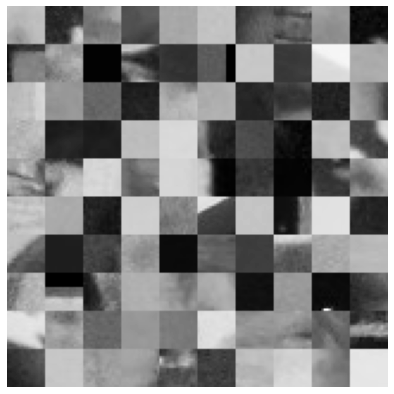

In [45]:
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

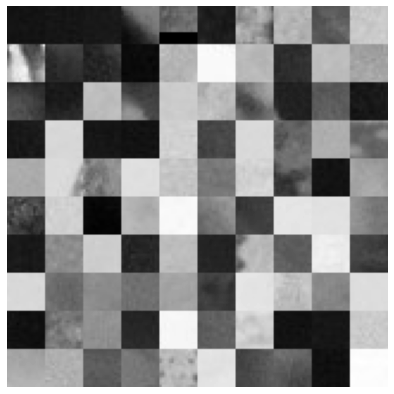

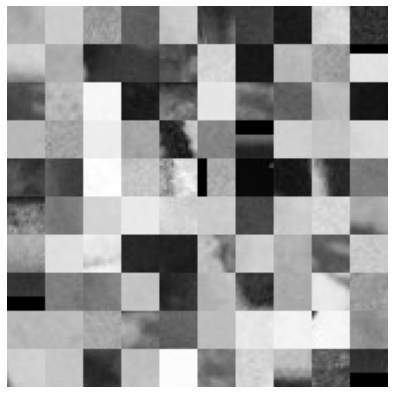

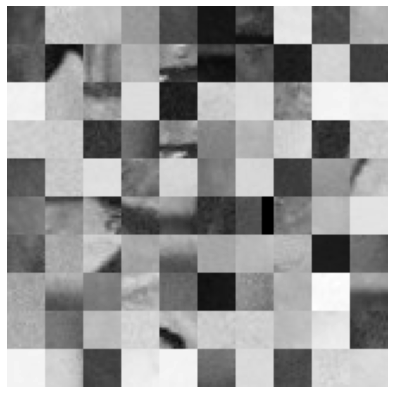

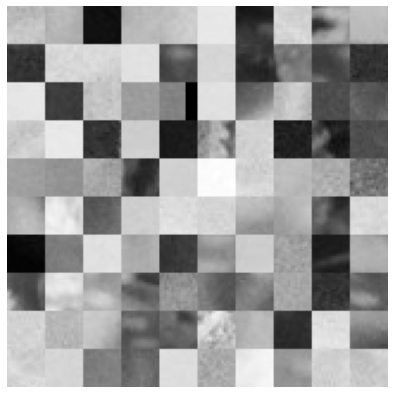

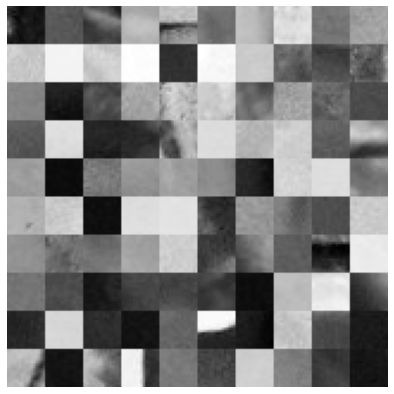

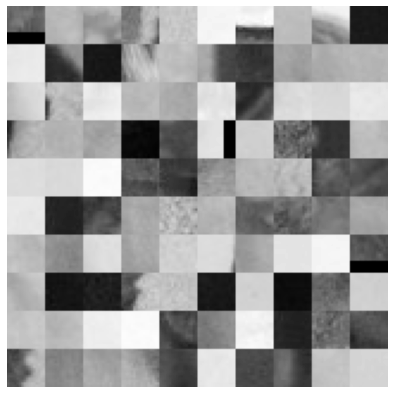

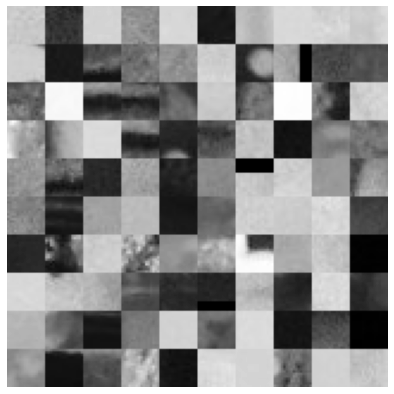

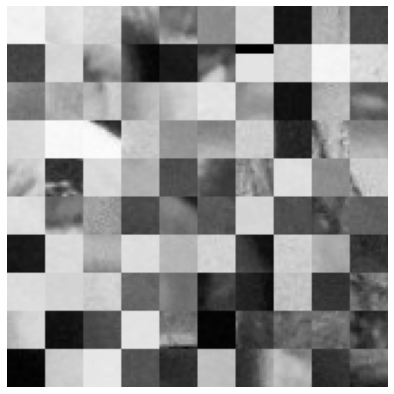

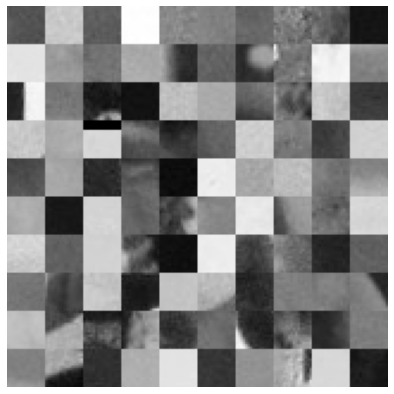

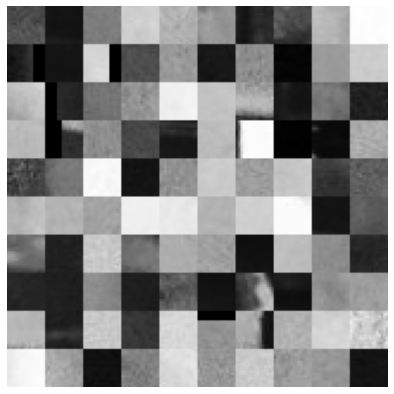

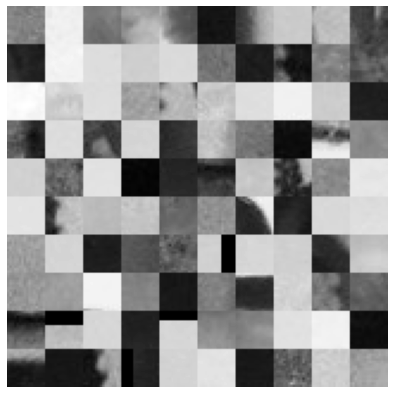

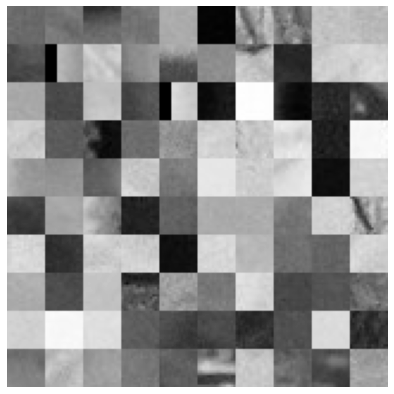

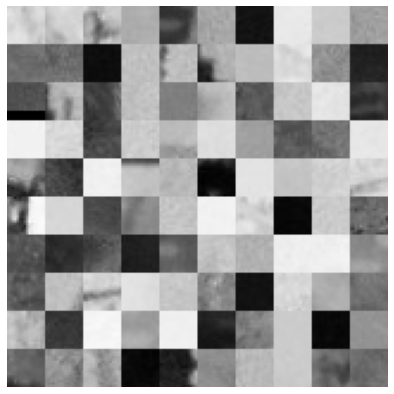

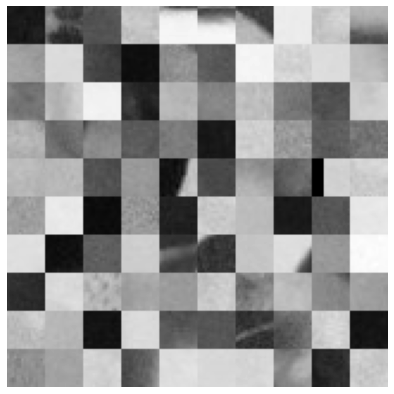

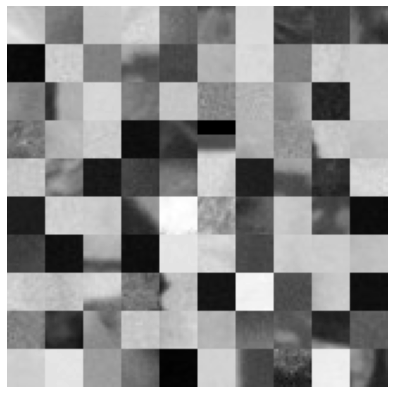

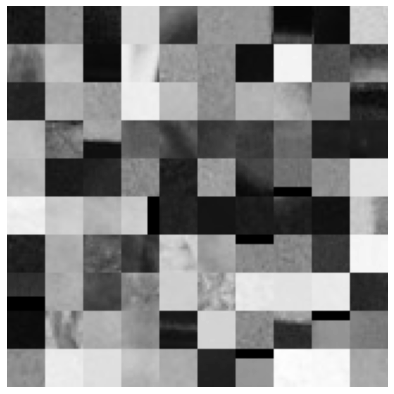

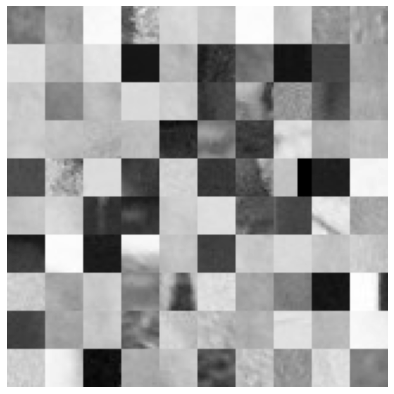

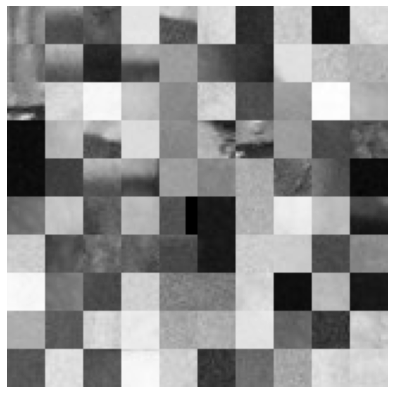

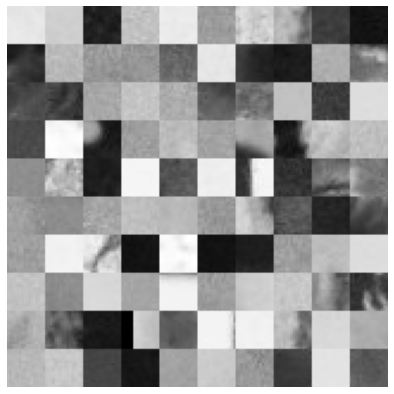

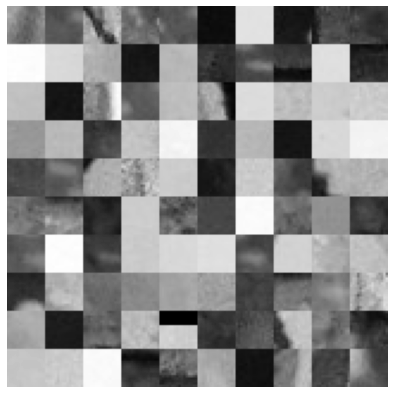

In [49]:
centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  dist = ((sift - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions